Para a comparação entre os modelos criados foi nescessário a simulação computacional do modelo encontrado no artigo do Lion, uma vez que o código deste modelo não estava disponível.

In [1]:
#Importando bibliotecas

%matplotlib inline
from numpy import *
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
#Definindo funções

def normal(z, zbar, V):
    return 1 / sqrt(2*pi*V) * exp(-(z-zbar)**2/(2*V))

def densidade(z, x, qtdz):
    soma = 0
    for j in range(qtdz):
        soma += x[1+j] * normal(z, x[1+2*qtdz+j], x[1+qtdz+j])
    return x[0] * soma

### Modelo base

\begin{equation}
\dfrac{dn_i}{dt} = (b(z_i) - d(z_i))n_i, \\
d(z_i) = d_0 + \sum_j c(z_j-z_i)n_j, \\
b(z_i) = b_0 - sz_i^2, \\
c(z_i) = exp\left(-\frac{
z_i^2}{2w^2}\right)
\end{equation}

In [3]:
#Parâmetros

num = 100
z = linspace(-1.5, 1.5, num)

b0 = 1
s = 0.1
w = 2
d0 = 0

dn = ones(num)

#Tempo
t = arange(0, 50., 1)

#Condições iniciais
x0 = array([1., 2/3, 1/3, 0.01, 0.01, 0.5, -0.5])
n0 = densidade(z, x0, 2)*3/num

def eq(n, t, z):
    def b(x):
        return b0-s*x**2
    def c(x):
        return exp(-x**2/(2*w**2))
    def d(x):
        soma = 0
        for j in range(num):
            soma = soma+ c(z[j] - x)*n[j]
        return d0 + soma
    for i in range(num):
        dn[i] = (b(z[i]) - d(z[i]))*n[i]
    return array(dn)

n = odeint(eq, n0, t, (z,))

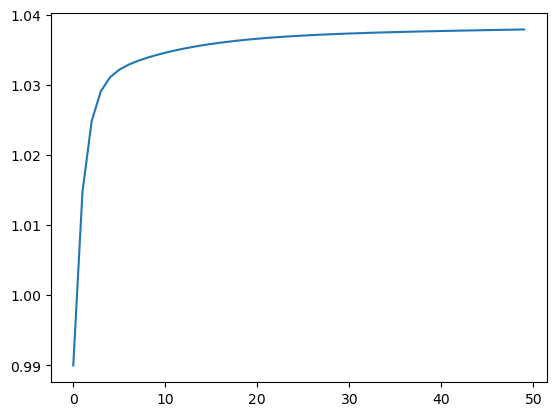

In [4]:
#Plotagem população total

ntotal = n.sum(axis=1)
plt.plot(t,ntotal)

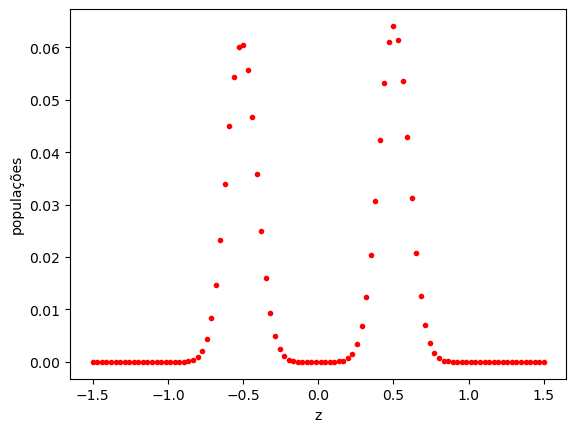

In [5]:
#Plot da densidade populacional no último tempo

plt.plot(z, n[-1], 'r.')
plt.xlabel('z')
plt.ylabel('populações')
plt.yscale('linear')

### Modelo OMD assexuado

\begin{align}
\dfrac{dn}{dt} &= \left[\sum_i f_ir(\overline{z}_i) + \dfrac{1}{2}\sum_i f_iV_i\dfrac{\partial^2 r}{\partial z^2}|_{z = \overline{z}_i}\right]n, \\
\dfrac{df_i}{dt} &= f_i\left(r(\overline{z}_i)-\sum_j f_jr(\overline{z}_j) \right)\\
\dfrac{dV_i}{dt} &= V_i^2\dfrac{\partial^2 r}{\partial z^2}|_{z = \overline{z}_i}\\
\dfrac{d\overline{z}_i}{dt} &= V_i\dfrac{\partial r}{\partial z}|_{z = \overline{z}_i} \\
b(z) &= b_0 - sz^2\\
c(x) &= exp\left(-\dfrac{x^2}{2w^2} \right)\\
d(z) &= d_0 + n\sum_j f_jc(\overline{z}_j-z)\\
r(z) &= b_0 - sz^2 - d_0 - n\sum_j f_j exp\left(-\frac{(\overline{z}_j-z)^2}{2w^2}\right)
\end{align}

Derivadas das funções

\begin{align}
c'(x) &= \dfrac{-x\  exp\left(-\dfrac{x^2}{2w^2}\right)}{w^2}\\
c''(x) &= (x^2-w^2)\dfrac{exp\left(-\dfrac{x^2}{2w^2}\right)}{w^4}\\
r'(z) &= -2sz + n\sum_j f_j c'(\overline{z}_j-z)\\
r''(z) &= -2s - n\sum_j f_j c''(\overline{z}_j-z)
\end{align}

In [22]:
#Parâmetros

num = 100
temp = 50

b0 = 1
s = 0.1
w = 2
d0 = 0
VM = 1e-5
qtdz = 2

#Tempo
t = arange(0, temp, 1)

#Condições iniciais
#n-0 f1-1 f2-2 V1-3 V2-4 z1barra-5 z2barra-6
x0 = array([1., 2/3, 1/3, 0.01, 0.01, 0.5, -0.5])

#Definindo modelo
def conjeq(x, t, b0, s, w, d0, VM, qtdz):
    def c(x):
        return exp(-x**2/(2*w**2))
    def cd1(x):
        return -x*exp(-x**2/(2*w**2))/w**2
    def cd2(x):
        return (x**2 - w**2)*exp(-x**2/(2*w**2))/w**4
    def r(z):
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*c(x[i+1+2*qtdz]-z)
        return b0 - s*z**2 - d0 - x[0]*soma
    def rbar():
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*r(x[i+1+2*qtdz])
        return soma
    
    rb = rbar()
    
    def rd1(z):
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*cd1(x[i+1+2*qtdz]-z)
        return -2*s*z+x[0]*soma
    def rd2(z):
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*cd2(x[i+1+2*qtdz]-z)
        return -2*s-x[0]*soma
    def df(j):
        return x[j]*(r(x[j + 2*qtdz]) - rb)
    def dn():
        soma1 = 0
        for i in range(qtdz):
            soma1 += x[i+1]*x[i+1+qtdz]*rd2(x[i+1+2*qtdz])
        return (rb + soma1/2)*x[0]
    ret = zeros_like(x)
    ret[0] = dn()
    for j in range(1, qtdz+1):
        ret[j] = df(j)
        ret[qtdz + j] = x[qtdz+j]**2 * rd2(x[2*qtdz + j]) + VM
        ret[2*qtdz+j] = x[qtdz+j]*rd1(x[2*qtdz+j])
    return ret

#Rodando aplicação
x = odeint(conjeq, x0, t, (b0, s, w, d0, VM, qtdz))

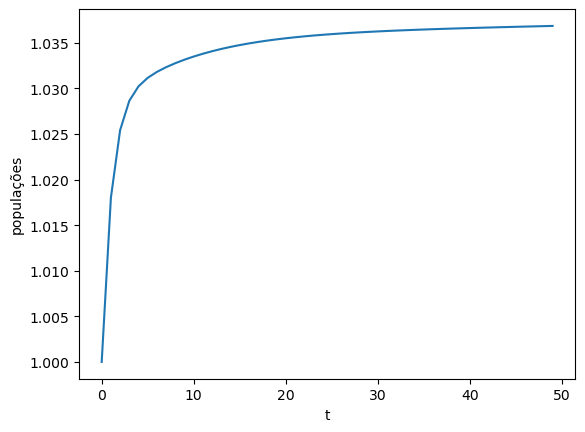

In [23]:
#Plot população total

plt.plot(t, x[:,0])
plt.xlabel('t') 
plt.ylabel('populações')
plt.yscale('linear')

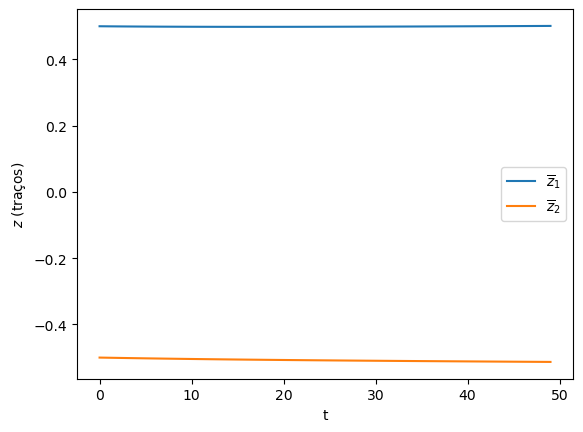

In [24]:
#Plot traço médio ao longo do tempo

plt.plot(t, x[:,5], label="$\\overline{z}_1$")
plt.plot(t, x[:,6], label="$\\overline{z}_2$")
plt.xlabel('t')
plt.ylabel("$z$ (traços)")
plt.yscale('linear')
plt.legend()

In [25]:
#Transformando em densidade populacional

z = arange(-1.5, 1.5, 0.0001)
n_olig = densidade(z, x[-1], 2)

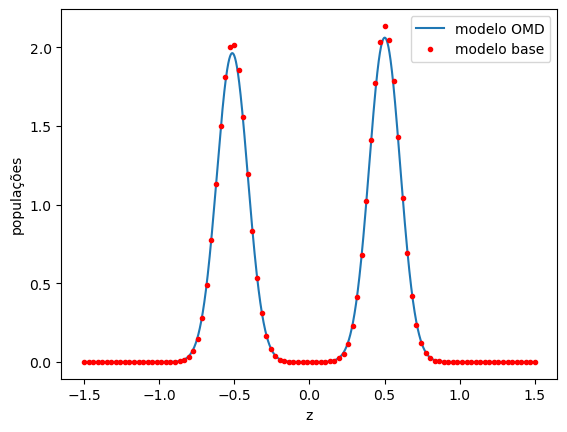

In [26]:
#Plotando densidade populacional OMD junto com a do modelo base

a = linspace(-1.5, 1.5, num)
plt.plot(z, n_olig, label="modelo OMD")
plt.plot(a, n[-1]*num/3, 'r.', label="modelo base")
plt.xlabel('z') 
plt.ylabel('populações')
plt.yscale('linear')
plt.legend()